Título: Signal to Noise

Data: 10/29/2020

Obj: Compute SNR based on the average of the flux per average of error (1-sigma calculated from variance).

Autor: Carlos Roberto

Description:
    As recommended by Vorbin code by Cappellari, we compute the average of the flux in the wavelength range of interest as the signal, and for the noise we use the average of 1-sigma error in te same range (1-sigma error was obtined from variance present in the data cube.)
    
    To know,
$1\sigma = \sqrt{variance}$

In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

data_folder = "/home/carlos/Desktop/pPXF(SDP)/"

In [2]:
position = np.loadtxt('Full_Spec_PixelPosition.txt')

for line in range(len(position)):
    x = position[line][1]
    y = position[line][0]

    file = (data_folder+'Data/FullSpec/%dx%d.fits'%(y,x)) #Coleta o  nome do arquivo
    hdu = fits.open(file) #Abre o arquivo .fits
        
    data = hdu[1].data #coleta o data
    var = hdu[2].data #coleta a variância
    noise = np.sqrt(var) #determina o erro a partir da variância
        
    signal = np.average(data) #calcula a média
    error = np.average(noise) #calcula a média
        
        #Escreve uma tabela com a posição de onde foi extraído (y,x) de cada espectro e o média do
            #sinal e do ruído calculados acima.
    newrow = [np.int(y),np.int(x),position[line][2], position[line][3],signal,error]
    if y == 0 and x == 0:
        table = np.array([np.int(y),np.int(x),position[line][2],position[line][3], signal,error])
    else:
        table = np.vstack([table,newrow]) 
        

In [3]:
np.savetxt('Full_Spec_SNR.txt',table, header= 'y_px x_px y_wcs('') x_wcs('') signal error', fmt='%i %i %18e %18e %.18e %.18e',delimiter=' ') #Salva a tabela

Now, we read the table with signal and noise, and discard pixels with SNR below some threshold. For now, we assume a minium SNR=2.

In [4]:
snr = np.loadtxt('Full_Spec_SNR.txt')

In [5]:
x = []
y = []
signal = []
noise = []
for i in range(len(snr)):
    if snr[i][4]/snr[i][5] > 2.0:
        x.append(snr[i][1])
        y.append(snr[i][0])
        signal.append(snr[i][4])
        noise.append(snr[i][5])

print(len(signal))

270


In [6]:
np.savetxt('Full_Spec_GoodPixels.txt',np.column_stack([y, x, signal, noise]), header='y_px x_px signal noise')

Here we display only the region with snr above 2.

In [7]:
from mpdaf.obj import Image
img = Image(data_folder+"Data/Muse_Image.fits") #Load cut data cube

 [astropy.io.fits.verify]


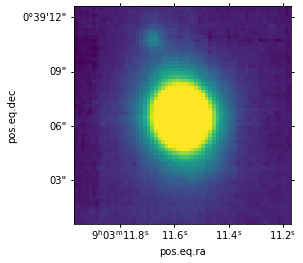

In [8]:
#Plot image of data cube, only for check
img.plot(use_wcs=True,zscale=True)

In [9]:
y, x, signal, noise = np.loadtxt("Full_Spec_GoodPixels.txt", unpack=True) #Read the table with pixel above snr = 2

In [10]:
img.data.data[:] = 0                                  #For all pixel in the image we atribute zero

for i in range(len(y)):                               #For pixels above the threshold we give its signal
    img.data.data[int(y[i])][int(x[i])] = signal[i]/noise[i]

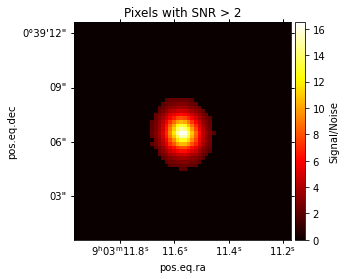

In [11]:
#Plot and save result

plot = img.plot(use_wcs=True, cmap='hot', colorbar='v', title="Pixels with SNR > 2")
plot.colorbar.set_label('Signal/Noise')
#plt.savefig("/home/carlos/Desktop/SDP/Dynamics/pPXF/Figs/GoodPixels.png",format='png')

In [12]:
img.write(data_folder+"Data/Voronoi/SNR.fits")